<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment1/workbook-task1.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TODO: Modify this cell to add your group name, group number and your names and student IDs

Group: 99

Authors:

In [1]:
import requests
import io
import pandas as pd
import xarray as xa

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load training/testing dataset

In [2]:
def load_dataset_from_url(url):
    """
    Loads a dataset from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    x: Input features in numpy array format
    y: Targets/labels in numpy array format
    """
    
    response = requests.get(url)
    response.raise_for_status()
    
    dataset = np.load(io.BytesIO(response.content)) 
    
    x, y = np.split(dataset, [9], axis=2)
    
    return x, y
    
    
# Downloading may take a while..
train_x, train_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/gVrTFgSJ1rWl1IN/download')
test_x, test_y = load_dataset_from_url('https://surfdrive.surf.nl/files/index.php/s/JR0WXbrzzTAmwEB/download')

print(f"train_x shape: {train_x.shape}")
print(f"train_y shape: {train_y.shape}\n")

print(f"test_x shape: {test_x.shape}")
print(f"test_y shape: {test_y.shape}")

train_x shape: (10000, 1000, 9)
train_y shape: (10000, 1000, 1)

test_x shape: (2000, 1000, 9)
test_y shape: (2000, 1000, 1)


### Visualize some of the training samples

In [3]:
#TODO Implement the solution to task 2 of assignment 1

train_y, test_y = train_y.squeeze(-1), test_y.squeeze(-1)

In [4]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
import numpy as np

In [5]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )
        self.rnn = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv(x).permute(0, 2, 1)
        x, (_, _) = self.rnn(x)
        x = self.fc(x)
        return x.permute(0, 2, 1)

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_dataLoader: torch.utils.data.Dataset,
                 validation_dataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_dataLoader = training_dataLoader
        self.validation_dataLoader = validation_dataLoader
        self.device = device
        self.epochs = epochs

    def run_trainer(self):
        train_losses_total = []
        val_losses_total = []
        for epoch in tqdm(range(self.epochs)):
            self.model.train()  # train mode
            train_losses=[]
            for batch in self.training_dataLoader:
                x, y = batch
                input, target = x.to(device=self.device, dtype=torch.float), y.to(self.device) # send to device (GPU or CPU)
                self.optimizer.zero_grad()  # zerograd the parameters
                out = self.model(input)  # one forward pass
                loss = self.criterion(out, target)  # calculate training loss

                loss_value = loss.item()
                train_losses.append(loss_value)

                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters

            self.model.eval()  # evaluation mode
            val_losses = []  # accumulate the losses here

            for batch in self.validation_dataLoader:
                x, y = batch
                input, target = x.to(device=self.device, dtype=torch.float), y.to(device=self.device)  # send to device (GPU or CPU)
                with torch.no_grad():
                    out = self.model(input)   # one forward pass
                    loss = self.criterion(out, target) # calculate validation loss
                  
                    loss_value = loss.item()
                    val_losses.append(loss_value)
                    
            print('Epoch:', epoch)
            print('Training loss,', np.mean(train_losses))
            print('Validation loss,', np.mean(val_losses))

            train_losses_total.append(np.mean(train_losses))
            val_losses_total.append(np.mean(val_losses))
          

        plt.plot(range(1, self.epochs + 1), train_losses_total, 'g', label='Training loss')
        plt.plot(range(1, self.epochs + 1), val_losses_total, 'b', label='Validation loss')

        plt.title('Training and Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig('loss.png')
        plt.show()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = xm.xla_device() if os.environ['COLAB_TPU_ADDR'] else torch.device('cpu')
BATCH_SIZE = 32
NUM_CLASSES = 6
NUM_FEATURES = 9
HIDDEN_SIZE = 128
NUM_RNN_LAYERS = 1
NUM_EPOCH = 150

In [8]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)
train_data = TensorDataset(torch.tensor(train_x), torch.tensor(train_y, dtype=torch.long))
val_data = TensorDataset(torch.tensor(val_x), torch.tensor(val_y, dtype=torch.long))
test_data = TensorDataset(torch.tensor(test_x), torch.tensor(test_y, dtype=torch.long))

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

model = RNNClassifier(input_size=NUM_FEATURES, hidden_size=HIDDEN_SIZE, num_classes=NUM_CLASSES, num_layers=NUM_RNN_LAYERS).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

trainer = Trainer(model=model, device=device, criterion=criterion, optimizer=optimizer, training_dataLoader=train_dataloader, validation_dataLoader=val_dataloader, epochs=NUM_EPOCH)

  1%|          | 1/150 [00:12<30:35, 12.32s/it]

Epoch: 0
Training loss, 1.7813359208106994
Validation loss, 1.7761573375217499


  1%|▏         | 2/150 [00:24<30:16, 12.27s/it]

Epoch: 1
Training loss, 1.7716278805732728
Validation loss, 1.7711497053267464


  2%|▏         | 3/150 [00:36<30:00, 12.25s/it]

Epoch: 2
Training loss, 1.7678604683876038
Validation loss, 1.7683957455650208


  3%|▎         | 4/150 [00:48<29:46, 12.24s/it]

Epoch: 3
Training loss, 1.7649985241889954
Validation loss, 1.7653538140039595


  3%|▎         | 5/150 [01:01<29:32, 12.22s/it]

Epoch: 4
Training loss, 1.7612072730064392
Validation loss, 1.7604972067333402


  4%|▍         | 6/150 [01:13<29:19, 12.22s/it]

Epoch: 5
Training loss, 1.7546934638023377
Validation loss, 1.751395619104779


  5%|▍         | 7/150 [01:25<29:07, 12.22s/it]

Epoch: 6
Training loss, 1.7413120279312133
Validation loss, 1.7308734182327512


  5%|▌         | 8/150 [01:37<28:54, 12.21s/it]

Epoch: 7
Training loss, 1.7062977032661437
Validation loss, 1.6700429992070274


  6%|▌         | 9/150 [01:49<28:43, 12.22s/it]

Epoch: 8
Training loss, 1.5901189451217652
Validation loss, 1.4715946307258


  7%|▋         | 10/150 [02:02<28:33, 12.24s/it]

Epoch: 9
Training loss, 1.3891576800346375
Validation loss, 1.3212831550174289


  7%|▋         | 11/150 [02:14<28:23, 12.25s/it]

Epoch: 10
Training loss, 1.30777543592453
Validation loss, 1.2791104619465177


  8%|▊         | 12/150 [02:26<28:15, 12.29s/it]

Epoch: 11
Training loss, 1.2710904211997986
Validation loss, 1.2411900493833754


  9%|▊         | 13/150 [02:39<28:05, 12.30s/it]

Epoch: 12
Training loss, 1.2270458817481995
Validation loss, 1.1746741873877389


  9%|▉         | 14/150 [02:51<27:54, 12.32s/it]

Epoch: 13
Training loss, 1.1537436270713806
Validation loss, 1.0904559862046015


 10%|█         | 15/150 [03:03<27:46, 12.34s/it]

Epoch: 14
Training loss, 1.0784749960899354
Validation loss, 1.0310970611042447


 11%|█         | 16/150 [03:16<27:35, 12.36s/it]

Epoch: 15
Training loss, 1.0375851039886475
Validation loss, 0.9955720333825975


 11%|█▏        | 17/150 [03:28<27:24, 12.36s/it]

Epoch: 16
Training loss, 1.0155962505340577
Validation loss, 0.9795976205477639


 12%|█▏        | 18/150 [03:41<27:11, 12.36s/it]

Epoch: 17
Training loss, 0.9972927579879761
Validation loss, 0.9618785948980422


 13%|█▎        | 19/150 [03:53<27:00, 12.37s/it]

Epoch: 18
Training loss, 0.9837203583717347
Validation loss, 0.9472400517690749


 13%|█▎        | 20/150 [04:05<26:48, 12.37s/it]

Epoch: 19
Training loss, 0.9703829996585845
Validation loss, 0.9291172103276328


 14%|█▍        | 21/150 [04:18<26:35, 12.37s/it]

Epoch: 20
Training loss, 0.9597966289520263
Validation loss, 0.9158892007101149


 15%|█▍        | 22/150 [04:30<26:22, 12.36s/it]

Epoch: 21
Training loss, 0.948568567276001
Validation loss, 0.9025340742535062


 15%|█▌        | 23/150 [04:42<26:10, 12.37s/it]

Epoch: 22
Training loss, 0.9386785635948182
Validation loss, 0.8919828988256908


 16%|█▌        | 24/150 [04:55<25:58, 12.37s/it]

Epoch: 23
Training loss, 0.929900028705597
Validation loss, 0.884141414884537


 17%|█▋        | 25/150 [05:07<25:45, 12.36s/it]

Epoch: 24
Training loss, 0.9213615739345551
Validation loss, 0.8812778620492845


 17%|█▋        | 26/150 [05:20<25:33, 12.37s/it]

Epoch: 25
Training loss, 0.9118349423408508
Validation loss, 0.8764277639843169


 18%|█▊        | 27/150 [05:32<25:21, 12.37s/it]

Epoch: 26
Training loss, 0.904509523153305
Validation loss, 0.8728064468928746


 19%|█▊        | 28/150 [05:44<25:09, 12.38s/it]

Epoch: 27
Training loss, 0.8976281638145447
Validation loss, 0.8662725213974242


 19%|█▉        | 29/150 [05:57<24:57, 12.38s/it]

Epoch: 28
Training loss, 0.890356968164444
Validation loss, 0.85390257456946


 20%|██        | 30/150 [06:09<24:45, 12.38s/it]

Epoch: 29
Training loss, 0.8848293595314026
Validation loss, 0.853035344963982


 21%|██        | 31/150 [06:21<24:32, 12.38s/it]

Epoch: 30
Training loss, 0.8770312612056732
Validation loss, 0.8381052509186759


 21%|██▏       | 32/150 [06:34<24:20, 12.38s/it]

Epoch: 31
Training loss, 0.8663847668170929
Validation loss, 0.8288935053916204


 22%|██▏       | 33/150 [06:46<24:07, 12.37s/it]

Epoch: 32
Training loss, 0.8582474303245544
Validation loss, 0.8222400981282431


 23%|██▎       | 34/150 [06:59<23:54, 12.37s/it]

Epoch: 33
Training loss, 0.8477877066135406
Validation loss, 0.8061645636482845


 23%|██▎       | 35/150 [07:11<23:42, 12.37s/it]

Epoch: 34
Training loss, 0.8330297346115112
Validation loss, 0.7944851016241407


 24%|██▍       | 36/150 [07:23<23:30, 12.37s/it]

Epoch: 35
Training loss, 0.8126003322601318
Validation loss, 0.7783705270479596


 25%|██▍       | 37/150 [07:36<23:17, 12.37s/it]

Epoch: 36
Training loss, 0.7841058666706086
Validation loss, 0.7471952466737657


 25%|██▌       | 38/150 [07:48<23:04, 12.37s/it]

Epoch: 37
Training loss, 0.7492916209697723
Validation loss, 0.6778387720622714


 26%|██▌       | 39/150 [08:00<22:52, 12.36s/it]

Epoch: 38
Training loss, 0.6917899270057678
Validation loss, 0.7203385640704443


 27%|██▋       | 40/150 [08:13<22:40, 12.37s/it]

Epoch: 39
Training loss, 0.6184348119497299
Validation loss, 0.5582241240947966


 27%|██▋       | 41/150 [08:25<22:29, 12.38s/it]

Epoch: 40
Training loss, 0.5821313494443894
Validation loss, 0.5341539387665097


 28%|██▊       | 42/150 [08:38<22:16, 12.38s/it]

Epoch: 41
Training loss, 0.5645143504142761
Validation loss, 0.509146839853317


 29%|██▊       | 43/150 [08:50<22:04, 12.38s/it]

Epoch: 42
Training loss, 0.5253191251754761
Validation loss, 0.4898224766292269


 29%|██▉       | 44/150 [09:02<21:52, 12.38s/it]

Epoch: 43
Training loss, 0.5008390908241271
Validation loss, 0.46477307402898393


 30%|███       | 45/150 [09:15<21:39, 12.38s/it]

Epoch: 44
Training loss, 0.4758034915924072
Validation loss, 0.4202502407724895


 31%|███       | 46/150 [09:27<21:27, 12.38s/it]

Epoch: 45
Training loss, 0.4582455185651779
Validation loss, 0.4163645094349271


 31%|███▏      | 47/150 [09:39<21:15, 12.38s/it]

Epoch: 46
Training loss, 0.44318280363082885
Validation loss, 0.3837534487247467


 32%|███▏      | 48/150 [09:52<21:03, 12.38s/it]

Epoch: 47
Training loss, 0.4274888939857483
Validation loss, 0.3928436627463689


 33%|███▎      | 49/150 [10:04<20:50, 12.38s/it]

Epoch: 48
Training loss, 0.4310880180597305
Validation loss, 0.3830754567706396


 33%|███▎      | 50/150 [10:17<20:38, 12.38s/it]

Epoch: 49
Training loss, 0.4075497781038284
Validation loss, 0.38582414152130245


 34%|███▍      | 51/150 [10:29<20:25, 12.38s/it]

Epoch: 50
Training loss, 0.4254132262468338
Validation loss, 0.3802431433919876


 35%|███▍      | 52/150 [10:41<20:12, 12.38s/it]

Epoch: 51
Training loss, 0.38156066787242887
Validation loss, 0.33211755468731835


 35%|███▌      | 53/150 [10:54<20:00, 12.38s/it]

Epoch: 52
Training loss, 0.4574715759754181
Validation loss, 0.7555607396458822


 36%|███▌      | 54/150 [11:06<19:48, 12.38s/it]

Epoch: 53
Training loss, 0.501445194363594
Validation loss, 0.43002411013557795


 37%|███▋      | 55/150 [11:18<19:36, 12.38s/it]

Epoch: 54
Training loss, 0.4348404095172882
Validation loss, 0.3779075959372142


 37%|███▋      | 56/150 [11:31<19:23, 12.38s/it]

Epoch: 55
Training loss, 0.39398918652534487
Validation loss, 0.35511403329788693


 38%|███▊      | 57/150 [11:43<19:12, 12.39s/it]

Epoch: 56
Training loss, 0.38098176193237304
Validation loss, 0.369285557951246


 39%|███▊      | 58/150 [11:56<18:58, 12.38s/it]

Epoch: 57
Training loss, 0.3669715076684952
Validation loss, 0.33908658959562815


 39%|███▉      | 59/150 [12:08<18:46, 12.38s/it]

Epoch: 58
Training loss, 0.35328268724679945
Validation loss, 0.31198199140647104


 40%|████      | 60/150 [12:20<18:34, 12.39s/it]

Epoch: 59
Training loss, 0.3475845130085945
Validation loss, 0.32036435083737447


 41%|████      | 61/150 [12:33<18:22, 12.39s/it]

Epoch: 60
Training loss, 0.33909649860858915
Validation loss, 0.30436576453466263


 41%|████▏     | 62/150 [12:45<18:10, 12.39s/it]

Epoch: 61
Training loss, 0.3294838417172432
Validation loss, 0.3018002961836164


 42%|████▏     | 63/150 [12:58<17:57, 12.39s/it]

Epoch: 62
Training loss, 0.3194410104751587
Validation loss, 0.27933093976406825


 43%|████▎     | 64/150 [13:10<17:45, 12.39s/it]

Epoch: 63
Training loss, 0.31798261642456055
Validation loss, 0.30519838678458383


 43%|████▎     | 65/150 [13:22<17:34, 12.40s/it]

Epoch: 64
Training loss, 0.3005536285638809
Validation loss, 0.26940526139168514


 44%|████▍     | 66/150 [13:35<17:21, 12.40s/it]

Epoch: 65
Training loss, 0.299678974032402
Validation loss, 0.2626612058707646


 45%|████▍     | 67/150 [13:47<17:10, 12.41s/it]

Epoch: 66
Training loss, 0.2950944364070892
Validation loss, 0.27267959382798934


 45%|████▌     | 68/150 [14:00<16:57, 12.41s/it]

Epoch: 67
Training loss, 0.2872236694097519
Validation loss, 0.2522473559966163


 46%|████▌     | 69/150 [14:12<16:46, 12.42s/it]

Epoch: 68
Training loss, 0.28102120506763456
Validation loss, 0.3356657120443526


 47%|████▋     | 70/150 [14:25<16:34, 12.43s/it]

Epoch: 69
Training loss, 0.28564746063947677
Validation loss, 0.24958521884585183


 47%|████▋     | 71/150 [14:37<16:22, 12.44s/it]

Epoch: 70
Training loss, 0.2705713451504707
Validation loss, 0.2672825824646723


 48%|████▊     | 72/150 [14:49<16:10, 12.44s/it]

Epoch: 71
Training loss, 0.263462547659874
Validation loss, 0.24451840396911378


 49%|████▊     | 73/150 [15:02<15:57, 12.43s/it]

Epoch: 72
Training loss, 0.25985458636283876
Validation loss, 0.2500675408140061


 49%|████▉     | 74/150 [15:14<15:43, 12.42s/it]

Epoch: 73
Training loss, 0.25417076218128204
Validation loss, 0.22852722827404265


 50%|█████     | 75/150 [15:27<15:31, 12.42s/it]

Epoch: 74
Training loss, 0.24879063045978547
Validation loss, 0.22917643780746158


 51%|█████     | 76/150 [15:39<15:18, 12.42s/it]

Epoch: 75
Training loss, 0.24561513537168503
Validation loss, 0.21558152754155416


 51%|█████▏    | 77/150 [15:51<15:06, 12.42s/it]

Epoch: 76
Training loss, 0.24230784875154496
Validation loss, 0.21922182019740816


 52%|█████▏    | 78/150 [16:04<14:54, 12.42s/it]

Epoch: 77
Training loss, 0.23782745963335036
Validation loss, 0.25634107395770056


 53%|█████▎    | 79/150 [16:16<14:41, 12.42s/it]

Epoch: 78
Training loss, 0.24173385965824126
Validation loss, 0.2241341048289859


 53%|█████▎    | 80/150 [16:29<14:29, 12.43s/it]

Epoch: 79
Training loss, 0.2317063655257225
Validation loss, 0.20417234183303892


 54%|█████▍    | 81/150 [16:41<14:17, 12.43s/it]

Epoch: 80
Training loss, 0.23023138344287872
Validation loss, 0.20792861188214923


 55%|█████▍    | 82/150 [16:54<14:05, 12.43s/it]

Epoch: 81
Training loss, 0.22955518162250518
Validation loss, 0.2095947577839806


 55%|█████▌    | 83/150 [17:06<13:52, 12.42s/it]

Epoch: 82
Training loss, 0.23019089770317078
Validation loss, 0.20984264380402035


 56%|█████▌    | 84/150 [17:18<13:40, 12.42s/it]

Epoch: 83
Training loss, 0.22610214203596116
Validation loss, 0.20163351699473367


 57%|█████▋    | 85/150 [17:31<13:28, 12.44s/it]

Epoch: 84
Training loss, 0.22268600553274154
Validation loss, 0.21227360079212795


 57%|█████▋    | 86/150 [17:43<13:15, 12.44s/it]

Epoch: 85
Training loss, 0.21810925936698913
Validation loss, 0.22575940428272126


 58%|█████▊    | 87/150 [17:56<13:03, 12.43s/it]

Epoch: 86
Training loss, 0.22204037433862686
Validation loss, 0.2033320667724761


 59%|█████▊    | 88/150 [18:08<12:50, 12.43s/it]

Epoch: 87
Training loss, 0.21486572140455246
Validation loss, 0.191281834055507


 59%|█████▉    | 89/150 [18:21<12:38, 12.43s/it]

Epoch: 88
Training loss, 0.21346999722719193
Validation loss, 0.23161990916918193


 60%|██████    | 90/150 [18:33<12:25, 12.43s/it]

Epoch: 89
Training loss, 0.2093021577000618
Validation loss, 0.19503446632907503


 61%|██████    | 91/150 [18:46<12:13, 12.44s/it]

Epoch: 90
Training loss, 0.20657838612794877
Validation loss, 0.2108064497274066


 61%|██████▏   | 92/150 [18:58<12:01, 12.44s/it]

Epoch: 91
Training loss, 0.20794779893755913
Validation loss, 0.19201923954108405


 62%|██████▏   | 93/150 [19:10<11:48, 12.43s/it]

Epoch: 92
Training loss, 0.20289780312776565
Validation loss, 0.19269979307575832


 63%|██████▎   | 94/150 [19:23<11:35, 12.42s/it]

Epoch: 93
Training loss, 0.20539242821931838
Validation loss, 0.1942480890050767


 63%|██████▎   | 95/150 [19:35<11:22, 12.42s/it]

Epoch: 94
Training loss, 0.2072645012140274
Validation loss, 0.19677502437243385


 64%|██████▍   | 96/150 [19:48<11:11, 12.43s/it]

Epoch: 95
Training loss, 0.1976040688455105
Validation loss, 0.18025543611674083


 65%|██████▍   | 97/150 [20:00<10:58, 12.43s/it]

Epoch: 96
Training loss, 0.2027337477207184
Validation loss, 0.19005915463443787


 65%|██████▌   | 98/150 [20:13<10:46, 12.42s/it]

Epoch: 97
Training loss, 0.212983510106802
Validation loss, 0.1981375924651585


 66%|██████▌   | 99/150 [20:25<10:33, 12.43s/it]

Epoch: 98
Training loss, 0.19540711107850076
Validation loss, 0.1793066934933738


 67%|██████▋   | 100/150 [20:37<10:21, 12.43s/it]

Epoch: 99
Training loss, 0.1933040618598461
Validation loss, 0.17955363340794095


 67%|██████▋   | 101/150 [20:50<10:08, 12.42s/it]

Epoch: 100
Training loss, 0.18891533663868904
Validation loss, 0.17371371293824817


 68%|██████▊   | 102/150 [21:02<09:56, 12.42s/it]

Epoch: 101
Training loss, 0.19037517270445822
Validation loss, 0.17340264694085197


 69%|██████▊   | 103/150 [21:15<09:44, 12.43s/it]

Epoch: 102
Training loss, 0.3059817996621132
Validation loss, 0.20124868480932145


 69%|██████▉   | 104/150 [21:27<09:31, 12.43s/it]

Epoch: 103
Training loss, 0.21068199497461318
Validation loss, 0.18151551106619457


 70%|███████   | 105/150 [21:39<09:18, 12.41s/it]

Epoch: 104
Training loss, 0.1979028314948082
Validation loss, 0.1818968935145272


 71%|███████   | 106/150 [21:52<09:06, 12.42s/it]

Epoch: 105
Training loss, 0.1880801208615303
Validation loss, 0.19207734508173807


 71%|███████▏  | 107/150 [22:04<08:54, 12.42s/it]

Epoch: 106
Training loss, 0.19083338952064513
Validation loss, 0.1832569812734922


 72%|███████▏  | 108/150 [22:17<08:42, 12.43s/it]

Epoch: 107
Training loss, 0.19163110533356667
Validation loss, 0.17852153534454013


 73%|███████▎  | 109/150 [22:29<08:30, 12.44s/it]

Epoch: 108
Training loss, 0.1843435565829277
Validation loss, 0.17413379594920173


 73%|███████▎  | 110/150 [22:42<08:17, 12.44s/it]

Epoch: 109
Training loss, 0.18725980308651924
Validation loss, 0.1795650739518423


 74%|███████▍  | 111/150 [22:54<08:04, 12.43s/it]

Epoch: 110
Training loss, 0.18253764748573303
Validation loss, 0.16494024899743853


 75%|███████▍  | 112/150 [23:06<07:52, 12.42s/it]

Epoch: 111
Training loss, 0.1780661535859108
Validation loss, 0.15677307877275679


 75%|███████▌  | 113/150 [23:19<07:39, 12.42s/it]

Epoch: 112
Training loss, 0.18045428597927093
Validation loss, 0.17865680536580464


 76%|███████▌  | 114/150 [23:31<07:27, 12.42s/it]

Epoch: 113
Training loss, 0.17769771134853363
Validation loss, 0.17534596177320633


 77%|███████▋  | 115/150 [23:44<07:15, 12.43s/it]

Epoch: 114
Training loss, 0.17413782858848573
Validation loss, 0.14907426883776984


 77%|███████▋  | 116/150 [23:56<07:02, 12.43s/it]

Epoch: 115
Training loss, 0.17708423560857772
Validation loss, 0.16448578983545303


 78%|███████▊  | 117/150 [24:09<06:50, 12.43s/it]

Epoch: 116
Training loss, 0.17077396723628044
Validation loss, 0.16307356338652354


 79%|███████▊  | 118/150 [24:21<06:37, 12.43s/it]

Epoch: 117
Training loss, 0.30905267915129664
Validation loss, 0.2079237973879254


 79%|███████▉  | 119/150 [24:33<06:25, 12.43s/it]

Epoch: 118
Training loss, 0.207038001537323
Validation loss, 0.17038900700826493


 80%|████████  | 120/150 [24:46<06:12, 12.43s/it]

Epoch: 119
Training loss, 0.19183375063538552
Validation loss, 0.17585677606245828


 81%|████████  | 121/150 [24:58<06:00, 12.43s/it]

Epoch: 120
Training loss, 0.1903691564500332
Validation loss, 0.17419576183671043


 81%|████████▏ | 122/150 [25:11<05:48, 12.43s/it]

Epoch: 121
Training loss, 0.1845524413883686
Validation loss, 0.16363710235981715


 82%|████████▏ | 123/150 [25:23<05:35, 12.43s/it]

Epoch: 122
Training loss, 0.1815223946273327
Validation loss, 0.16457332457814897


 83%|████████▎ | 124/150 [25:36<05:23, 12.43s/it]

Epoch: 123
Training loss, 0.17952843111753464
Validation loss, 0.18193306123453473


 83%|████████▎ | 125/150 [25:48<05:10, 12.43s/it]

Epoch: 124
Training loss, 0.17478085967898369
Validation loss, 0.1678234538625157


 84%|████████▍ | 126/150 [26:01<04:58, 12.44s/it]

Epoch: 125
Training loss, 0.17600849625468254
Validation loss, 0.16628720871512853


 85%|████████▍ | 127/150 [26:13<04:46, 12.44s/it]

Epoch: 126
Training loss, 0.17070406970381738
Validation loss, 0.15628417971588315


 85%|████████▌ | 128/150 [26:25<04:33, 12.44s/it]

Epoch: 127
Training loss, 0.17290770763158797
Validation loss, 0.15445496425742195


 86%|████████▌ | 129/150 [26:38<04:21, 12.43s/it]

Epoch: 128
Training loss, 0.17066314575076102
Validation loss, 0.19817776717836894


 87%|████████▋ | 130/150 [26:50<04:08, 12.43s/it]

Epoch: 129
Training loss, 0.1698202486038208
Validation loss, 0.16139058603180778


 87%|████████▋ | 131/150 [27:03<03:56, 12.43s/it]

Epoch: 130
Training loss, 0.16659512120485306
Validation loss, 0.1500092623016191


 88%|████████▊ | 132/150 [27:15<03:43, 12.43s/it]

Epoch: 131
Training loss, 0.16825796535611154
Validation loss, 0.14387331441754386


 89%|████████▊ | 133/150 [27:28<03:31, 12.43s/it]

Epoch: 132
Training loss, 0.16799839562177657
Validation loss, 0.1443834990736038


 89%|████████▉ | 134/150 [27:40<03:18, 12.42s/it]

Epoch: 133
Training loss, 0.16322172111272812
Validation loss, 0.13696224620890995


 90%|█████████ | 135/150 [27:52<03:06, 12.43s/it]

Epoch: 134
Training loss, 0.16276497954130173
Validation loss, 0.1448013096574753


 91%|█████████ | 136/150 [28:05<02:54, 12.43s/it]

Epoch: 135
Training loss, 0.16961317414045335
Validation loss, 0.16695167289839852


 91%|█████████▏| 137/150 [28:17<02:41, 12.43s/it]

Epoch: 136
Training loss, 0.156878391623497
Validation loss, 0.13666608030833896


 92%|█████████▏| 138/150 [28:30<02:29, 12.44s/it]

Epoch: 137
Training loss, 0.15594314488768576
Validation loss, 0.13903218436808812


 93%|█████████▎| 139/150 [28:42<02:16, 12.44s/it]

Epoch: 138
Training loss, 0.16283816513419153
Validation loss, 0.20730695790714687


 93%|█████████▎| 140/150 [28:55<02:04, 12.44s/it]

Epoch: 139
Training loss, 0.15377434274554252
Validation loss, 0.1475357978589951


 94%|█████████▍| 141/150 [29:07<01:51, 12.44s/it]

Epoch: 140
Training loss, 0.1499905870258808
Validation loss, 0.14608514214318896


 95%|█████████▍| 142/150 [29:19<01:39, 12.43s/it]

Epoch: 141
Training loss, 0.16211581313610077
Validation loss, 0.14032955562311505


 95%|█████████▌| 143/150 [29:32<01:27, 12.43s/it]

Epoch: 142
Training loss, 0.15324641191959382
Validation loss, 0.1363810073761713


 96%|█████████▌| 144/150 [29:44<01:14, 12.43s/it]

Epoch: 143
Training loss, 0.14885854789614678
Validation loss, 0.1385947126481268


 97%|█████████▋| 145/150 [29:57<01:02, 12.42s/it]

Epoch: 144
Training loss, 0.15328689989447594
Validation loss, 0.13141155585883155


 97%|█████████▋| 146/150 [30:09<00:49, 12.42s/it]

Epoch: 145
Training loss, 0.14814390510320663
Validation loss, 0.14063535181302872


 98%|█████████▊| 147/150 [30:22<00:37, 12.43s/it]

Epoch: 146
Training loss, 0.1541564780175686
Validation loss, 0.16110637961398988


 99%|█████████▊| 148/150 [30:34<00:24, 12.43s/it]

Epoch: 147
Training loss, 0.1711102640926838
Validation loss, 0.1374213352562889


 99%|█████████▉| 149/150 [30:46<00:12, 12.43s/it]

Epoch: 148
Training loss, 0.14883857637643813
Validation loss, 0.14122190101752205


100%|██████████| 150/150 [30:59<00:00, 12.40s/it]

Epoch: 149
Training loss, 0.15038082000613212
Validation loss, 0.13322283765153278


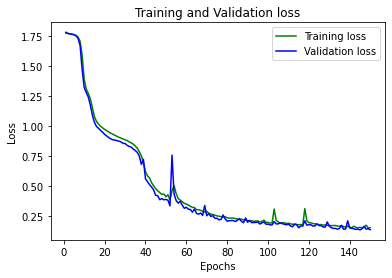

In [9]:
trainer.run_trainer()

In [10]:
def predict(test_dataloader, model, device):
    model.eval()
    outputs = []
    for batch in tqdm(test_dataloader):
        x, y = batch
        input, target = x.to(device=device, dtype=torch.float), y.to(device=device)  # send to device (GPU or CPU)
        with torch.no_grad():
            output = model(input)   # one forward pass
            outputs.append(torch.argmax(output, dim=1).cpu().detach().numpy())
    return np.vstack(outputs)

test_pred = predict(test_dataloader, model, device)

100%|██████████| 63/63 [00:01<00:00, 59.29it/s]


In [11]:
acc = np.sum(test_pred == test_y) / (test_y.shape[0] * test_y.shape[1])
print(acc)

0.955118
